##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [34]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from multiprocessing import Pool
from functools import partial
from sklearn import metrics

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
import MiscFuncs as MF
importlib.reload(Dense)
importlib.reload(RSTF)
importlib.reload(MF)

# %matplotlib inline

%matplotlib notebook
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
# from sklearn.externals import joblib
from matplotlib import cm

from scipy import stats

from ipywidgets import FloatProgress, HTML
from IPython.display import display, clear_output
import os  
import shutil
from keras import backend as K
try:pool.close()
except:pass

import json
import os


def Test(params,X,y,YScaled,XScaled,pool):
    return(np.random.rand(params['K']))


def ModSelect(Scope,Site):
    if Site == 'Illisarvik':
        if Scope == 'Full':
            Model = ['PPFD_Avg','AirTC_Avg','VPD','wind_speed',
                    'Temp','VWC','Sedge','Shrub','Grass','Upland',
                    'HR','DOY']
        if Scope == 'Test':
            Model = ['PPFD_Avg','VPD','wind_speed','VWC']
    if Site == 'FishIsland':
        BaseFactors = []
#         if Scope == 'Full':
        Model=['AirTC_Avg','VPD','NR_Wm2_Avg','PPFD_Avg',
               'Table_1','VWC_2','Active_Layer_1',
               'Temp_2_5_1','Temp_5_1','Temp_15_1','Temp_2_5_2','Temp_5_2','Temp_15_2',
               'u*','wind_speed','air_pressure','Wind_Direction']               
#         if Scope == 'Test':
#             Model=['AirTC_Avg','VPD','NR_Wm2_Avg','PPFD_Avg',
#                    'Table_1','VWC_2','Active_Layer_1','Hour','DOY',
#                    'Temp_2_5_1','Temp_5_1','Temp_15_1','Temp_2_5_2','Temp_5_2','Temp_15_2',
#                    'u*','wind_speed','air_pressure','Wind_Direction']  
#             Model=['AirTemp','Rainfall_Tot','SoilMoist(4)','SoilMoist(5)','Net_SW_Wm2_Avg',
#                    'Net_LW_Wm2_Avg','Net_Ttl_Rad_Avg','WindSpd','Delta_SoilMoist(4)','Delta_SoilMoist(5)']
    return(Model)

def Stats(mse,se,r2,j,params,i=0):
    df = pd.DataFrame(index = [str(j)+'_'+str(params['N'])],
                      data={'Model':[params['Model']],'MSE':[mse],'Size':j,'Nodes':params['N'],
                            'SE':[se],'r2':[r2],'Performance':0,'K':[params['K']]})
    return(df)

def t(p,n):
    alpha = 1-p
    df = n-1
    return(stats.t.ppf(alpha,df))
MP = False
MP = True
Scope = 'Full'
# Scope = 'Test'
if MP == True:
    processes = 3
else:
    processes = 1
# memory = .95/processes
    
cwd = os.getcwd()
Site='FishIsland'
# Site = 'Illisarvik'
alpha = .05

pd.set_option('max_colwidth',200)
def Display (tar,prog1=None,prog2=None,MdLs=None,MdL=None):
    clear_output()
    display(tar)
    if prog1!=None:
        display(prog1)
    if prog2!=None:
        display(prog2)
    if MdLs!=None:
        display(MdLs)
    if MdL!=None:
        display(MdL)
    
tar = HTML(
            value=" ",
            placeholder='Target: ',
            description='Target: ',
        )
kwt = HTML(
        value=str(0),
        placeholder='Quit Score: ',
        description='Quit Score: ',
        )


Path = 'C:\\Users\\wesle\\NetworkAnalysis\\FishIsland/'   
# try:
#     shutil.rmtree(Path)
# except:
#     pass
try:
    os.mkdir(Path+'/')
except:
    pass
# print(Path)

In [35]:
def RecWrite(AllRes,Path):
    for f in AllRes.keys():
        try:
            os.mkdir(Path)
        except:
            pass
        for t in AllRes[f].keys():
            if t != 'Results' and t != 'Records' and t!= 'Removed':
                for p in AllRes[f][t].keys():
                    if t == 'X':
                        np.save(Path+f+'_'+t+'_'+str(p)+'.npy',AllRes[f][t][p][0])
                        
                    else:
                        for p2 in AllRes[f][t][p].keys():
                            np.save(Path+f+'_'+t+'_'+str(p)+'_'+str(p2)+'.npy',AllRes[f][t][p][p2])
        AllRes[f]['Records'].to_csv(Path+f+'_Runs.csv')
        AllRes[f]['Results'].to_csv(Path+f+'_Results.csv')
#         file=open(Path+f+'_Removed.txt','w')
#         s1=','.join(AllRes[f]['Removed'])
#         file.write(s1)
#         file.close()
        
def RecRead(Path):
    AllRes={}
    for f in ['fco2','fch4']:
        AllRes[f]={}
        AllRes[f]['Records']=pd.read_csv(Path+f+'_Runs.csv',index_col=0)
        AllRes[f]['Results']=pd.read_csv(Path+f+'_Results.csv',index_col=0)
#         temp=open(Path+f+'_Removed.txt', "r")
#         AllRes[f]['Removed'] = temp.read().split(',')
        AllRes[f]['Derivatives']={}
        AllRes[f]['SSQ'] ={}
        AllRes[f]['X'] = {}
        AllRes[f]['Yhat'] = {}
        AllRes[f]['Ytrue'] = {}
        AllRes[f]['Outputs'] = {}

#         for filename in os.listdir(Path):
#             if filename.endswith(".npy") and filename.split('.')[0].split('_')[0]==f:
# #                 print(filename)
#                 AllRes[f][filename.split('.')[0].split('_')[1]][int(filename.split('.')[0].split('_')[2])]={}
#                 AllRes[f][filename.split('.')[0].split('_')[1]][int(filename.split('.')[0].split('_')[2])]\
#                 [int(filename.split('.')[0].split('_')[-1])]=np.load(Path+filename)
    return(AllRes)

SE_Rule = 1

In [36]:
# depth = 15
# SE_Rule=1
Time = time.time()
AllRes={}
if __name__ == '__main__':
#     try:
#         shutil.rmtree(Path+'/'+target+'/')
#         os.mkdir(Path+'/')
#     except:pass
    for target in ['fch4','fco2']:#
        try:
            shutil.rmtree(Path+'/'+target+'/')
        except:
            pass
        try:
            os.mkdir(Path+'/'+target+'/')
        except:
            pass
        AllRes[target]={}
#         AllRes[target]['Results'] = {}
        AllRes[target]['Derivatives'] = {}
        AllRes[target]['SSQ'] ={}
        AllRes[target]['X'] = {}
        AllRes[target]['Yhat'] = {}
        AllRes[target]['Ytrue'] = {}
        AllRes[target]['Outputs'] = {}
#         AllRes[target]['Removed']={}
#         AllRes[target]['Factors'] = []
        Rm = []
        Input=ModSelect(Scope,Site)
        
        
        start = len(Input)
        IpKey=np.arange(0,start)
        IpDict={'Factors':Input.copy(),'Key':IpKey}
#         try:
#             shutil.rmtree(Path+'/'+target+'/')
#         os.mkdir(Path+'/'+target+'/')  
#         except:pass
        tar.value=target
        prog2 = FloatProgress(min=0, max=100,description='Bootstrapping:')
        MdL = HTML(value=" ",placeholder='Testing: ',description='Testing: ')
#         Display (tar,prog2=prog2,MdL=MdL)
        Continue = True
        first = 1
        run = 0
        while run <2:
            j = len(Input)
            AllRes[target]['Derivatives'][j] = {}
            AllRes[target]['SSQ'][j] ={}
            AllRes[target]['Yhat'][j] = {}
            AllRes[target]['Ytrue'][j] = {}
            AllRes[target]['Outputs'][j] = {}
            for num in [150,100,50]:
                Time2 = time.time()
                params = Dense.Params(Scope,target,MP=MP)#,Act='sigmoid')
                params['Dpath'] = cwd+'/'+Site+'/'

                params['Inputs'] = Input
                MdL.value='N = '+str(j)+':  '+str(params['Inputs'])
                Display (tar,prog2=prog2,MdL=MdL)
                print('Inputs!: ', params['Inputs'])
                print('Total Runtime: ',time.time()-Time)
                print('Training Time: ', time.time()-Time2)
                params['Model'] = '+'.join(params['Inputs'])
                RST = RSTF.ReadStandardTimeFill(params,'AllData.csv')#,resample='2H')
        #             RST = RSTF.ReadStandardTimeFill(params,'TagluData.csv')#,resample='2H')
                if target == 'ER':
                    RST.Master = RST.Master.loc[RST.Master['fco2']>0]
                RST.Master['Night']=0
                RST.Master['Month']=RST.Master.index.month
                RST.Master.loc[RST.Master['PPFD_Avg']<1,'Night']=2
                RST.Master['Night'] *= RST.Master['Month']

                Ni = len(Input)
                Ns = int(RST.Master[target].count()*(1-params['validation_split']))
                No = 1
    #             a = 2
#                 num = int(Ns/(a*(Ni+No)))
#                 num = int(Ns/a)
                params['N']= num
                print(num)

                params['Sname'] = 'Y_'
                params['Spath'] = Path+target+'/'+str(j)+'_'+str(num)+'/'
                os.mkdir(params['Spath'])
                RST.Scale(params['target'],params['Inputs']) 
                y = RST.y*1.0
                X = RST.X*1.0
    #             print(X,y)
    #             params['N']=2
    #             print(params['N'])
                #Rule by Maier et al. 1998
    #             A = int(a*Ni+No)
    #             B = int(Ns/((Ni+No)))
    #             if A<B:params['N']=A
    #             else:params['N']=B

                params['Memory'] = (math.floor(100/params['proc'])- 5/params['proc']) * .01
                Y_hat=[]
                y_true=[]
                X_true=[]
                index=[]
                ones=[]
                prog2.value=0
                Avs = []
                Derivatives = []
                Outputs=[]
                if MP == False:
                    for k in range(params['K']):
                        results = Dense.Bootstrap(k,params=params,X=X,y=y)
                        Y_hat.append(RST.YScaled.inverse_transform(results[0]))
                        y_true.append(RST.YScaled.inverse_transform(results[1]))
                        X_true.append(RST.XScaled.inverse_transform(results[2]))
                        ones.append(results[3])
                        prog2.value=(k+1)/params['K']*100
                        Avs.append(results[4])
                        Derivatives.append(results[5])
                        Outputs = results[6]
                else:
                    pool = Pool(processes=processes,maxtasksperchild=75)
                    for k,results in enumerate(pool.imap_unordered(partial(Dense.Bootstrap,params=params,X=X,y=y,
                                                                          Stratify=RST.Data.Night
                                                                          ),range(params['K']))):
    #                     print(k)
                        Y_hat.append(RST.YScaled.inverse_transform(results[0]))
                        y_true.append(RST.YScaled.inverse_transform(results[1]))
                        X_true.append(RST.XScaled.inverse_transform(results[2]))
                        ones.append(results[3])
                        prog2.value=(k+1)/params['K']*100
                        Avs.append(results[4])
                        Derivatives.append(results[5])
                        Outputs.append(results[6])
                    pool.close()
                Y_hat = np.squeeze(np.asanyarray(Y_hat))
                y_true = np.squeeze(np.asanyarray(y_true))
                X_true = np.asanyarray(X_true)
                ones = np.asanyarray(ones)
                params['Memory'] = .95
                results = Dense.Sort_outputs(0,params=params,Y_hat=Y_hat,y_true=y_true,X_true=X_true,ones=ones)
                mse,se,r2 = results
                Level = Stats(mse,se,r2,j,params,i=num)
                Level.to_csv('Temp.csv')
    #             prog1.value=start-j#+i/len(Inputs)
                Level['Thresh'] = Level['MSE']+Level['SE']
                Min = Level.loc[Level['MSE']==Level['MSE'].min()]
                if first == 1:
                    Records = Level
                else:
                    Records = Records.append(Level)
                Av = np.array(Avs).mean(axis=0)
#                 print(Av)
                Drv = np.array(Derivatives)#.mean(axis=0)
#                 Av = (Drv.mean(axis=0)**2).sum(axis=1)
#                 print(Av)
                Range = Drv.mean(axis=0).max(axis=1)-Drv.mean(axis=0).min(axis=1)
#                 SE = (np.array(Avs).T/np.array(Avs).sum(axis=1)).T
                SE = np.array(Avs).std(axis=0)**.5/(params['K']**.5)
                if first==2:
                    IpDict['RC_Sum: '+str(j) +'_'+ str(num)]=np.zeros(Results.shape[0])
                    IpDict['RC: '+str(j) +'_'+ str(num)]=np.zeros(Results.shape[0])
                    IpDict['RG: '+str(j) +'_'+ str(num)]=np.zeros(Results.shape[0])#Av/Av.sum()
                    IpDict['SE: '+str(j) +'_'+ str(num)]=np.zeros(Results.shape[0])#Av/Av.sum()
                    IpDict['CS: '+str(j) +'_'+ str(num)]=np.zeros(Results.shape[0])
                else:
                    first = 2
                Results = pd.DataFrame(data=IpDict)
                for I,A,S,R in zip(Input,Av,SE,Range):
                    Results.loc[Results['Factors']==I,'RC: '+str(j)+'_'+ str(num)]=A
                    Results.loc[Results['Factors']==I,'RG: '+str(j)+'_'+ str(num)]=R
                    Results.loc[Results['Factors']==I,'SE: '+str(j)+'_'+ str(num)]=S
                Results['RC_Sum: '+str(j)+'_'+ str(num)]=Results['RC: '+str(j)+'_'+ str(num)]/Results['RC: '+str(j)+'_'+ str(num)].sum()

                IpDict['RC_Sum: '+str(j)+'_'+ str(num)]=Results['RC_Sum: '+str(j)+'_'+ str(num)].values
                IpDict['RC: '+str(j)+'_'+ str(num)]=Results['RC: '+str(j)+'_'+ str(num)].values
                IpDict['RG: '+str(j)+'_'+ str(num)]=Results['RG: '+str(j)+'_'+ str(num)].values
                IpDict['SE: '+str(j)+'_'+ str(num)]=Results['SE: '+str(j)+'_'+ str(num)].values
                Results = Results.sort_values('RC: '+str(j)+'_'+ str(num))
                Resluts = Results.reset_index()
                Results['CS: '+str(j)+'_'+ str(num)]=Results['RC_Sum: '+str(j)+'_'+ str(num)].sort_values(ascending=False).cumsum().sort_values(ascending=False)


                Results = Results.sort_values('Key')

                IpDict['CS: '+str(j)+'_'+ str(num)]=Results['CS: '+str(j)+'_'+ str(num)].values

                Min = Records.loc[Records['MSE']==Records['MSE'].min()]

                AllRes[target]['Records'] = Records
                AllRes[target]['Results'] = Results
    #                 AllRes[target]['Removed'] = Rm
                AllRes[target]['Derivatives'][j][num] = Drv
                AllRes[target]['SSQ'][j][num] = Avs
                AllRes[target]['X'][j] = X_true
                AllRes[target]['Outputs'][j][num] = Outputs
                AllRes[target]['Yhat'][j][num] = Y_hat
                AllRes[target]['Ytrue'][j][num] = y_true
            
            if run == 0:
                Min = Records.loc[Records['MSE']==Records['MSE'].min()]
#                 Best = Records.loc[Records['MSE']<=Min['MSE'].values[0]+Min['SE'].values[0]*SE_Rule]
#                 Best = Best.loc[Best['Nodes']==Best['Nodes'].min()]  
                K = Min.index.values[0]
                for k in Results.loc[((Results['CS: '+K]>.9)&(Results['RC: '+K]>0)),'Factors'].values:
#                 for k in Results.loc[((Results['RC_Sum: '+K]<.025)&(Results['RC: '+K]>0)),'Factors'].values:
                    print(k)
                    Input.remove(k)
            run +=1
    #             AllRes[target]['Factors'].append(j)
    #                 num +=1
RecWrite(AllRes,Path)

HTML(value='fco2', description='Target: ', placeholder='Target: ')

FloatProgress(value=100.0, description='Bootstrapping:')

HTML(value="N = 9:  ['VPD', 'NR_Wm2_Avg', 'PPFD_Avg', 'VWC_2', 'Active_Layer_1', 'Temp_5_1', 'Temp_5_2', 'Temp…

Inputs!:  ['VPD', 'NR_Wm2_Avg', 'PPFD_Avg', 'VWC_2', 'Active_Layer_1', 'Temp_5_1', 'Temp_5_2', 'Temp_15_2', 'u*']
Total Runtime:  3745.3003268241882
Training Time:  0.013963460922241211
50


C:\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:709: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):


In [37]:
# 
# Results = AllRes['fch4']['Results']
print(Best.index.values)
# print(Results.loc[((Results['RC: '+K]<.025)&(Results['RC: '+K]>0)),'Factors'])
# RecWrite(AllRes,Path)
# print(Results.loc[Results['CS: 17_114']<.9].sort_values(by='CS: 17_114'))
# print(Results.loc[((Results['CS: '+K]>.9)&(Results['RC: '+K]>0)),['CS: '+K,'SE: '+K]])

['10_100']


                                                                                                                                                                       Model  \
17_150  AirTC_Avg+VPD+NR_Wm2_Avg+PPFD_Avg+Table_1+VWC_2+Active_Layer_1+Temp_2_5_1+Temp_5_1+Temp_15_1+Temp_2_5_2+Temp_5_2+Temp_15_2+u*+wind_speed+air_pressure+Wind_Direction   
17_100  AirTC_Avg+VPD+NR_Wm2_Avg+PPFD_Avg+Table_1+VWC_2+Active_Layer_1+Temp_2_5_1+Temp_5_1+Temp_15_1+Temp_2_5_2+Temp_5_2+Temp_15_2+u*+wind_speed+air_pressure+Wind_Direction   
17_50   AirTC_Avg+VPD+NR_Wm2_Avg+PPFD_Avg+Table_1+VWC_2+Active_Layer_1+Temp_2_5_1+Temp_5_1+Temp_15_1+Temp_2_5_2+Temp_5_2+Temp_15_2+u*+wind_speed+air_pressure+Wind_Direction   
9_150                                                                                            VPD+NR_Wm2_Avg+PPFD_Avg+VWC_2+Active_Layer_1+Temp_5_1+Temp_5_2+Temp_15_2+u*   
9_100                                                                                            VPD+NR_Wm2_Avg+PPFD_Avg

<IPython.core.display.Javascript object>


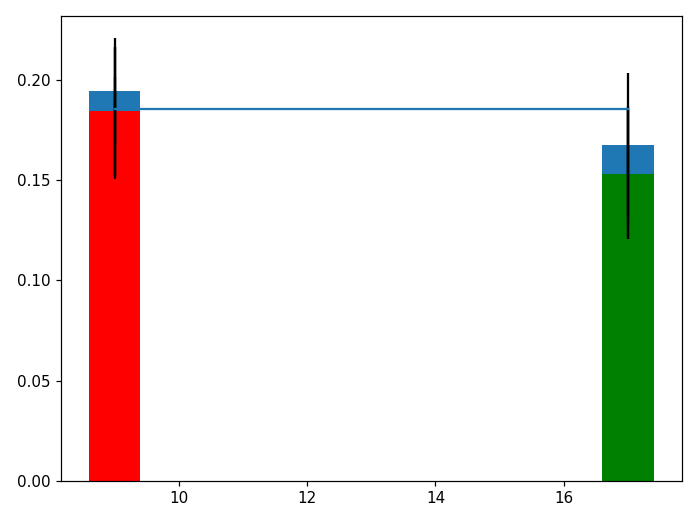

                                                                             Model  \
9_100  VPD+NR_Wm2_Avg+PPFD_Avg+VWC_2+Active_Layer_1+Temp_5_1+Temp_5_2+Temp_15_2+u*   

            MSE  Size  Nodes        SE        r2  Performance   K    Thresh  \
9_100  0.184239     9    100  0.031996  0.917996            0  30  0.216235   

           RMSE  
9_100  0.429231  
9
100
(2571, 9)


<IPython.core.display.Javascript object>


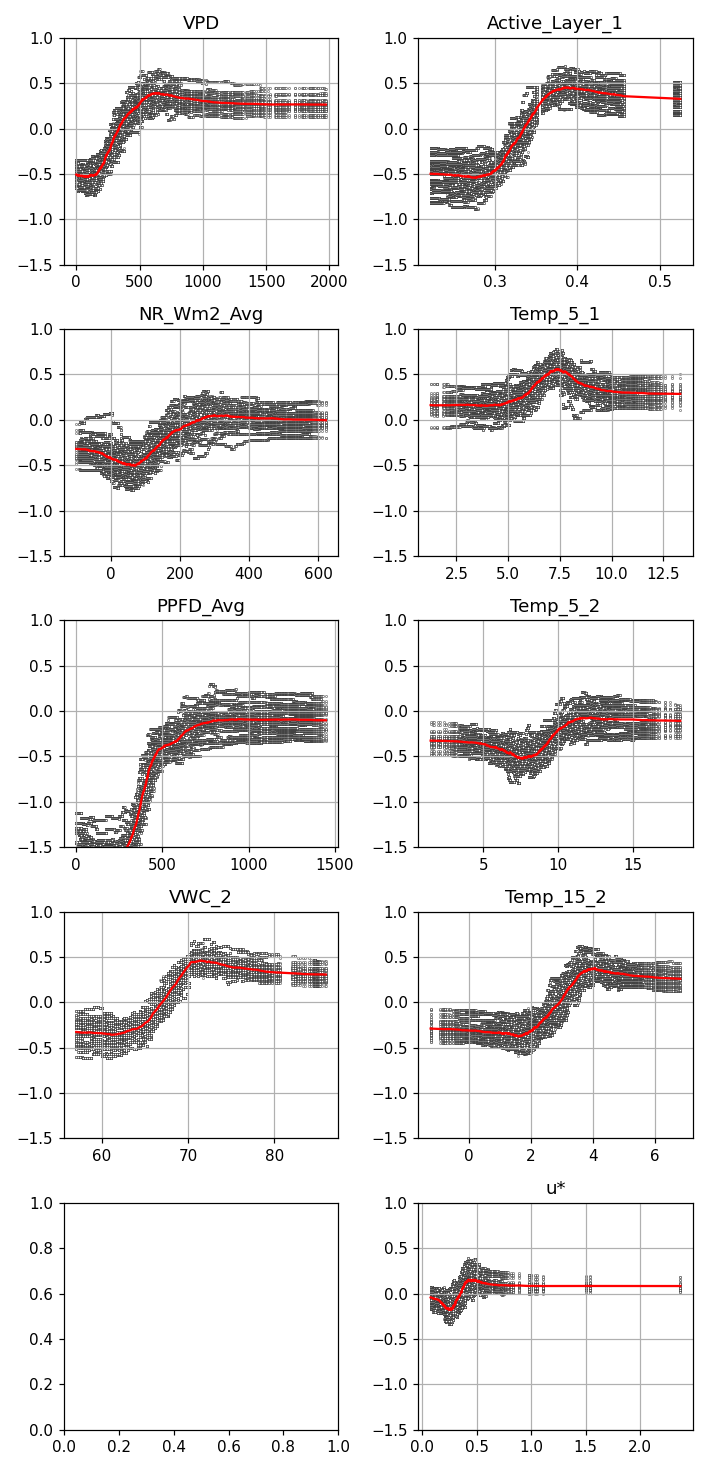

    CS: 9_100  RC_Sum: 9_100         Factors
0    1.000000       0.000000       AirTC_Avg
14   1.000000       0.000000      wind_speed
10   1.000000       0.000000      Temp_2_5_2
9    1.000000       0.000000       Temp_15_1
15   1.000000       0.000000    air_pressure
7    1.000000       0.000000      Temp_2_5_1
16   1.000000       0.000000  Wind_Direction
4    1.000000       0.000000         Table_1
13   1.000000       0.007635              u*
12   0.992365       0.035873       Temp_15_2
2    0.956492       0.047481      NR_Wm2_Avg
11   0.909011       0.047907        Temp_5_2
5    0.861103       0.048003           VWC_2
8    0.813100       0.050081        Temp_5_1
1    0.763019       0.064913             VPD
6    0.698106       0.066169  Active_Layer_1
3    0.631937       0.631937        PPFD_Avg
VPD 0
NR_Wm2_Avg 1
PPFD_Avg 2
VWC_2 3
Active_Layer_1 4
Temp_5_1 5
Temp_5_2 6
Temp_15_2 7
u* 8


In [43]:
F = 'fco2'
AllRes = RecRead(Path)
Results = AllRes[F]['Results']
try:
    Results = Results.drop(columns='Key')
except:
    pass
Labels = ((Results.set_index('Factors')*-1)**.5+1).fillna(0).sum(axis=1).sort_values(ascending=False).index.values

SE_Rule = 1
AllRes[F]['Records']['RMSE']=(AllRes[F]['Records']['MSE']**.5)
Records = AllRes[F]['Records']
print(Records)

plt.figure()
# Min = Records.loc[Records['Size']==Records['Size'].min()]
Min = Records.loc[Records['MSE']==Records['MSE'].min()]
Best = Records.loc[Records['MSE']<=Min['MSE'].values[0]+Min['SE'].values[0]*SE_Rule]
Best = Best.loc[Best['Size']==Best['Size'].min()]
Best = Best.loc[Best['Nodes']==Best['Nodes'].min()]
print(Best)
plt.bar(Records['Size'],Records['MSE'],yerr=Records['SE'])
plt.bar(Best['Size'],Best['MSE'],yerr=Best['SE'],color='r')
plt.bar(Min['Size'],Min['MSE'],yerr=Min['SE'],color='g')
# plt.xticks(Records['Nodes'],Labels,rotation=80)
line = [Min['MSE'].values[0]+Min['SE'].values[0]*SE_Rule,Min['MSE'].values[0]+Min['SE'].values[0]*SE_Rule]
plt.plot([Records['Size'].min(),Records['Size'].max()],line)
# print(Best)
plt.tight_layout()
Size_best = Best.Size.values[0]
Nodes_best = Best.Nodes.values[0]

Size = Size_best
print(Size)
Nodes = Nodes_best
print(Nodes)
# Size=Records.Size.min()
# print(AllRes[F]['Derivatives'][Size])


# AllRes[F][Derivatives][Size][Nodes]=np.load(Path+F+'_Derivatives_'+str(Size)+'_'+str(Nodes)+'.npy')
Derivatives = np.load(Path+F+'_Derivatives_'+str(Size)+'_'+str(Nodes)+'.npy')
Mean = Derivatives.mean(axis=0)
X = np.load(Path+F+'_X_'+str(Size)+'.npy')
print(X.shape)

if Size>2:
    fig,ax = plt.subplots(int((Size+1)/2),2,figsize = (6.5,Size*1.5))
else:
    fig,ax = plt.subplots(2,2,figsize = (6.5,4*1.5))
k = 0
j=0
TD = []
i = 0
mx,mn=-1,1
PD = {}
# plot = 'Table_1'
# a
m = -.495

a = 'RC: '+Best.index.values[0]
ase = 'SE: '+Best.index.values[0]

print(Results[['CS: '+Best.index.values[0],'RC_Sum: '+Best.index.values[0],
               'Factors']].sort_values(by='RC_Sum: '+Best.index.values[0]))


# print(Results[['CS: 20_50','RC_Sum: 20_50',
#                'Factors']].sort_values(by='RC_Sum: 20_50'))
for f,r in zip(Results.Factors.values,Results[a].values):
#     print()
#     print(f,r)
    if r > 0:
        print(f,i)
#         if f == plot:
        if i >Size/2-1:
            j=1
            k = (math.floor(Size/2))
        for p in range(Derivatives.shape[0]):
#             print(p,i)
#             print(Derivatives[p][i].shape)
            Temp = pd.DataFrame(data={'X':X[:,i],'Y':(Derivatives[p][i].flatten())})#-m)*X[:,i].std()-X[:,i].mean()})
            Temp = Temp.sort_values(by='X')
            ax[i-k,j].scatter(Temp['X'],Temp['Y'],c='white',s=2,edgecolor='k',linewidth=.25)
#             ax[i].scatter(Temp['X'],Temp['Y'],c='k',s=2)
#             ax.scatter(Temp['X'],Temp['Y'],c='k',s=2)
            if Derivatives[p][i].max()>mx:
                mx=Derivatives[p][i].max()
            if Derivatives[p][i].min()<mn:
                mn=Derivatives[p][i].min()
#         print(Mean[i].shape)
        Temp = pd.DataFrame(data={'X':X[:,i],'Y':(Mean[i].flatten())})#-m)*X[:,i].std()-X[:,i].mean()})
        Temp = Temp.sort_values(by='X')

        ax[i-k,j].plot(Temp['X'],Temp['Y'],color='r')#.scatter(X[:,i],Mean[i],color='k',s=10)
        ax[i-k,j].set_title(f)
        ax[i-k,j].grid()
        ax[i-k,j].set_ylim(-1.5,1)


        TD.append([f,Mean[i].min(),Mean[i].max(),Mean[i].mean(),Mean[i].max()-Mean[i].min(),(Mean[i]**2).sum()])
        i +=1
# print(mn,mx)
# plt.setp(ax, ylim=[mn-m,mx-m])
plt.tight_layout()
Statistics = pd.DataFrame(data=TD,columns=['Factor','Min','Max','Mean','Range','SSQ'])

# print(Statistics.sort_values('Range'))
plt.savefig(F+'Derivs.png')

<IPython.core.display.Javascript object>


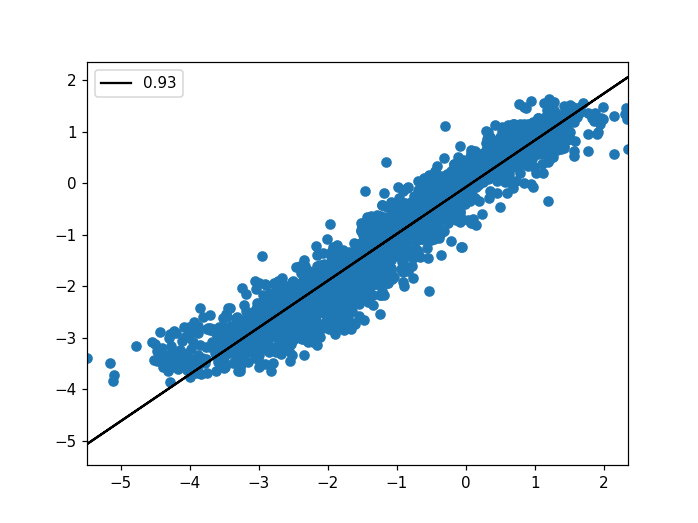

(-5.481733999341057, 2.3507418452733755)

In [44]:
plt.figure()
y = np.load(Path+F+'_Yhat_'+str(Size)+'_'+str(Nodes)+'.npy').mean(axis=0)
x = np.load(Path+F+'_Ytrue_'+str(Size)+'_'+str(Nodes)+'.npy').mean(axis=0)
slope,intercept,r,p,SE = stats.linregress(x,y)
# print(Op)
plt.scatter(x,y)#(AllRes['fch4'].keys())
plt.plot(x,intercept+slope*x,label=str(np.round(r**2,2)),color='k')
plt.legend()
plt.xlim(x.min(),x.max())
plt.ylim(x.min(),x.max())
# print(Results)

<IPython.core.display.Javascript object>


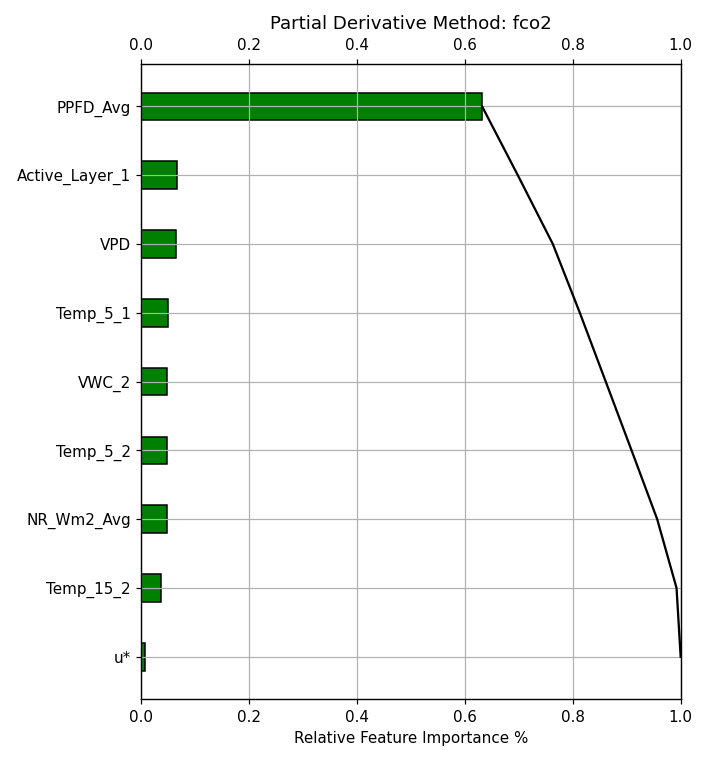

In [45]:


try:
    Results = Results.loc[Results[a]>0].sort_values(a,ascending=True).reset_index()
except:
    pass

# print(a)
# print(Results[a],Results['RC: '+b],)
# print(Results.Factors.values[1:])
# print(Results[a])
fig,ax=plt.subplots(figsize=(6.5,7))
ax.barh(Results.index,Results['RC_Sum: '+Best.index.values[0]],#xerr=Results[ase],
         height=.4,color='g',edgecolor='k')
# ax.barh(Results.index+.45,Results['RC: '+b],xerr=Results['SE: '+b],
#          height=.4,color='r',edgecolor='k')
ax2=ax.twiny()
# Results['Cumsum']=Results[a].sort_values(ascending=False).cumsum().sort_values(ascending=False)
ax2.plot(Results['CS: '+Best.index.values[0]],Results.index,color='k')

# print(Results[['Factors','Cumsum']])
# plt.barh(Results.index+.5,Results['RC: '+Min],xerr=Results['SE: '+Min],height=.5,color='r')
ax.set_yticks(Results.index)
ax.set_yticklabels(Results['Factors'].values)
# plt.xticks(rotation=90)

ax.set_xlabel('Relative Feature Importance %')
ax.set_title('Partial Derivative Method: '+F)
ax.grid()
ax.set_xlim(0,1)
ax2.set_xlim(0,1)
plt.tight_layout()
# plt.show()

plt.savefig('PAD_'+F+'_PrunedFactors.png')
